<a href="https://colab.research.google.com/github/TaviTragus/data-science-fundamentals/blob/main/Unit3/TaviTragU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cardinal Population Density One Mile From 183#


In [ ]:
!pip install "preliz[full,notebook]"
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 467.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=

##Intro##

I panicked and chose a random data set that I had access to: my old Plearth data for the population estimate of cardinals in northeast district park. We did a study in bird population density (based on proximity to a highway), so every data point is in birds per hectare. We gathered data by walking transects six times (there were three people at three different distances from the highway). In this model I will be predicting the population density of the far transect.

##The Data##


This is my raw data, very few data points because we gathered it by hand. Surely that won't cause any problems for me later, right?

In [ ]:
#importing data!
url_bird = 'https://raw.githubusercontent.com/TaviTragus/data-science-fundamentals/refs/heads/main/Unit3/BirdRawData%20-%20Sheet1.csv'
data_bird = pd.read_csv(url_bird)
data_bird

,1,2,3
0,11.70,4.5,1.6
1,7.18,4.5,2.6
2,16.66,4.8,2.3
3,9.57,6.0,2.9
4,8.51,4.5,2.0
5,5.32,4.5,2.4


(array([[0., 0., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 4., 2., 0., 0., 0., 0., 0., 0., 0.],
        [6., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([ 1.6  ,  3.106,  4.612,  6.118,  7.624,  9.13 , 10.636, 12.142,
        13.648, 15.154, 16.66 ]),
 <a list of 3 BarContainer objects>)

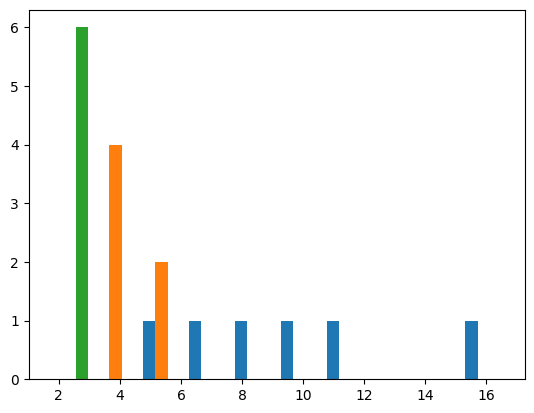

In [ ]:
plt.hist(data_bird)

##Prior##

For the prior, I chose the inverse gamma distribution because it has an early peak that fits what I remember about cardinals (the bird we studied). It has a domain of $(0, \infty)$. I chose the numbers 2.5 and 18 because the peak of the distribution covers what I think the population density is with some room for error.

/usr/local/lib/python3.10/dist-packages/preliz/distributions/inversegamma.py:177: RuntimeWarning: divide by zero encountered in divide
  prob = gammaincc(alpha, beta / x)


<Axes: >

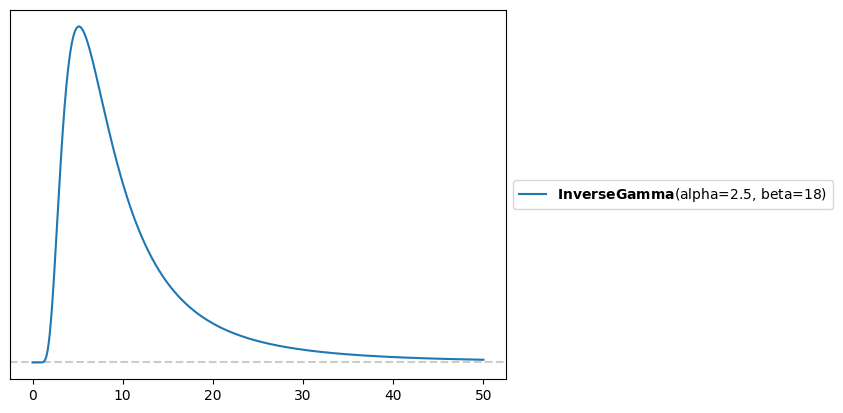

In [ ]:
priorfar = pz.InverseGamma(alpha = 2.5, beta = 18)
priorfar.plot_pdf(support=(0,50))

In [ ]:
priorfar.mean(),priorfar.skewness(), priorfar.kurtosis, priorfar.var()

(array(12.),
 array(nan),
 <bound method InverseGamma.kurtosis of InverseGamma(alpha=2.5, beta=18)>,
 array(288.))

##Model 1: Gamma Distribution##


For the first try, I am using a Gamma distribution because it looks sort of like the shape I 'expect' (is that the right way to say that?) and google says it is versatile.

In [ ]:
#G is for Gamma distribution
with pm.Model() as model_birdG:
    #weak-ish prior for shape
    alpha1 = pm.InverseGamma('alpha', alpha = 2.5, beta = 18)
    #weak scale, i think
    beta1 = pm.Uniform('beta', 5, 17)

    #first likelihood
    y = pm.Gamma('y', alpha = alpha1, beta = beta1, observed=data_bird['1'])

    idata_birdG = pm.sample(1000)

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_birdG, model=model_birdG, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

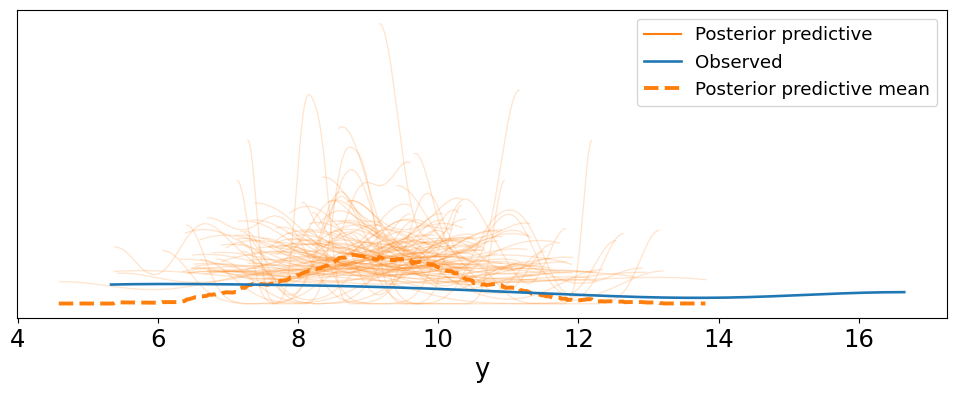

In [ ]:
az.plot_ppc(idata_birdG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I had a lot of trouble getting a PPC, I kept getting the error:

And that was because I was using mu and sigma as my parameters for the Gamma distribution (or at least it was fixed by replace mu and sigma with alpha and beta).

###PPC Commentary###
So that didn't work, I don't expect the match to be very good for any because the observed data is really small.

##Model 2: Normal Distribution##

I decided to do a normal distribution because it is simple and symmetrical, and I guess six data points that are mostly evenly spaced could be mostly symmetrical.

In [ ]:
#N is for Normal distribution
with pm.Model() as model_birdN:
    #weak-ish prior for mean
    mu2 = pm.InverseGamma('mu', alpha = 2.5, beta = 18)
    #uniform distribution for standard deviation
    sigma2 = pm.Uniform('sigma', 0, 10)

    #second likelihood
    y = pm.Normal('y', mu = mu2, sigma = sigma2, observed=data_bird['1'])

    idata_birdN = pm.sample(1000)

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
pm.sample_posterior_predictive(idata_birdN, model=model_birdN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

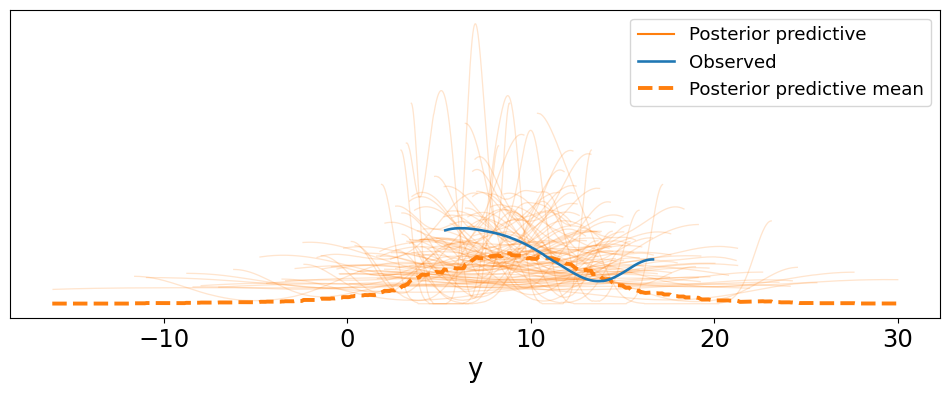

In [ ]:
az.plot_ppc(idata_birdN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I forgot to find a distribution that can only be positive :(
Also I think this is worse than the first model. Um that didn't work very well, I am not sure what to do from here, I want to try a normal distribution again, just restrict it to positive numbers.

##Model 3: Log Normal Distribution##

I feel less confident in using this distribution as my likelyhood because it has a long tail, and I don't expect there to be significantly more birds than we counted. It is similar to the normal distribution butonly positive, and I like that.

In [ ]:
#L is for Log Normal distribution
with pm.Model() as model_birdL:
    #weak-ish prior for mean
    mu3 = pm.InverseGamma('mu', alpha = 2.5, beta = 18)
    #uniform distribution for standard deviation
    sigma3 = pm.Uniform('sigma', 0, 10)

    #second likelihood
    y = pm.LogNormal('y', mu = mu3, sigma = sigma3, observed=data_bird['1'])

    idata_birdL = pm.sample(1000)

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_birdL, model=model_birdL, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 30.0)

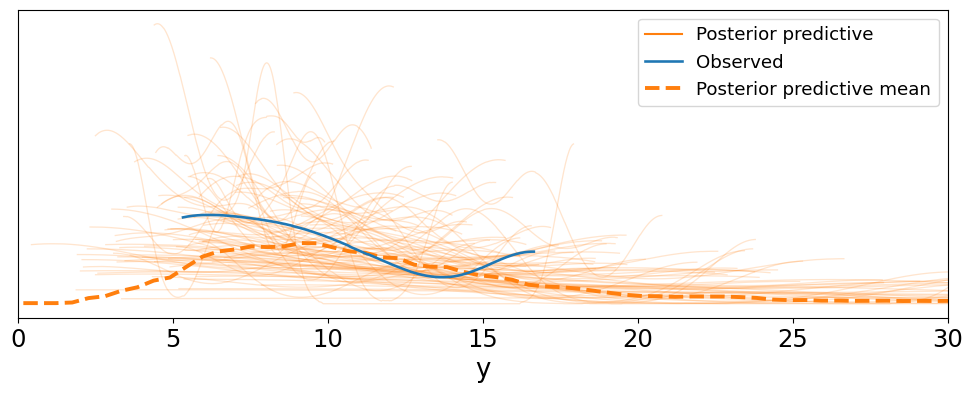

In [ ]:
axL = az.plot_ppc(idata_birdL, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
axL.set_xlim(0, 30)

MMMmmmmm yep thats what I thought would happen, but it was worth a shot. The log normal distribution skewed everything way higher than I think it should be. My data doesn't have very many patters, but based ont he way that we collected it, I would not expect there to be hundreds more birds than we observed.

##Model 4: Chi Distribution##

I'm just scrolling through wikipedia looking for distributions, who knows what will or won't work? This does look kinda like what a want: a bell-adjacent curve that is only positive and drops off quickly.

In [ ]:
#C is for Chi distribution
with pm.Model() as model_birdC:
    #weak-ish prior for mean
    nu4 = pm.InverseGamma('nu', alpha = 2.5, beta = 18)

    #second likelihood
    y = pm.ChiSquared('y', nu = nu4, observed=data_bird['1'])

    idata_birdC = pm.sample(1000)

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_birdC, model=model_birdC, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

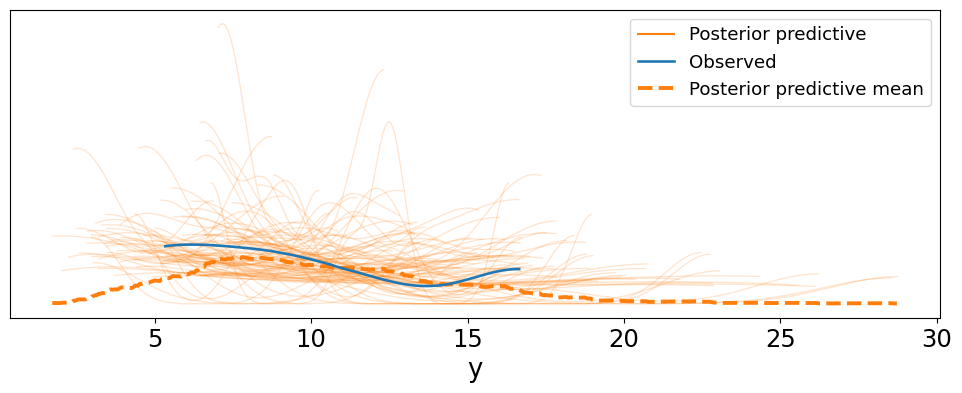

In [ ]:
axL = az.plot_ppc(idata_birdC, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Despite choosing a random distribution, I think this was the best model so far. I am fine with some of the posterier predictive lines going to 30 because a hectare is rather large, so a lot of birds can live in one. There are still a few lines that shoot up into the sky, I don't really like those.

##Model 5: Poisson Distribution##

The preliz documentation describes this as being "used to model the number of events occurring in a fixed period of time when the times at which events occur are independent." This is sort of accurate, except the events are nto entirely independent and I am counting the number of events (birds) per place instead of per time. Hopefully a poisson likelyhood works well!

In [ ]:
#P is for Poisson distribution
with pm.Model() as model_birdP:
    #weak-ish prior for mean
    mu5 = pm.InverseGamma('mu', alpha = 2.5, beta = 18)

    #second likelihood
    y = pm.Poisson('y', mu = mu5, observed=data_bird['1'])

    idata_birdP = pm.sample(1000)

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_birdP, model=model_birdP, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

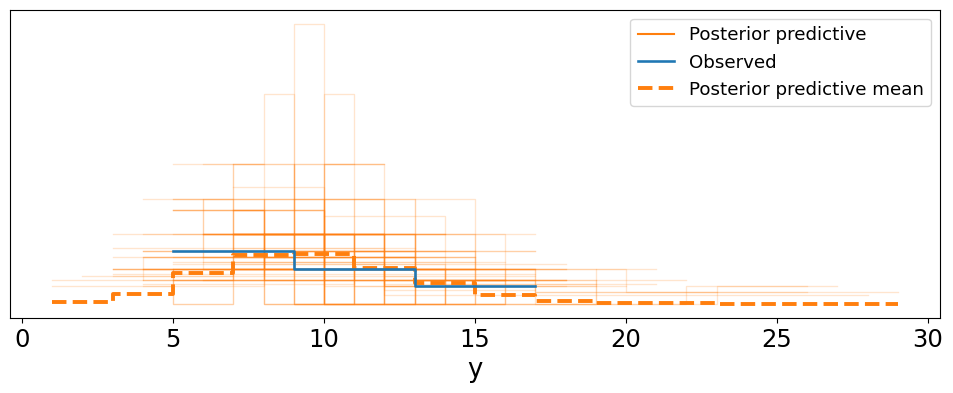

In [ ]:
axL = az.plot_ppc(idata_birdP, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I forgot that Poisson is not continuous, but I'm not mad about the graphs blockyness. The data did come from counting birds (then doing math with the number of birds counted), so discreetness does make sense. I am however upset that the blockyness is 'tall'. I think this works ok, but the ChiSquared model still works better.

#Lame, Mr. Arredondo said my data was too small after I asked about it earlier and it was fine :(#

#Citlaly Gutierrez Earned Runs Per Game#

##Intro##

I am once again turning to look at Citlaly Gutierrez's stats, for many reasons. She is still in college, so we can check our model against how she does in her next two years at UT. She is local (attends UT Austin), so her stats are valuable to people that care about college sports. And softball pitchers have a lot of special stats and hose stats are well documented.

In this I will be looking at Gutierrez's Earned Runs (ER) (note: this is NOT earned run average per game). An earned run is a run that scores despite the defenses best effort. A batter that is aided in base running by a defensive error and scores does not count as an earned run. Earned Run Average (ERA) is how many runs a pitcher would have earned, given they pitched with the same quality for a whole game. ERA extrapolates data from ER to a whole game, if a pitcher didn't pitch the whole game.

##Data##

In [ ]:
url_er = 'https://raw.githubusercontent.com/TaviTragus/data-science-fundamentals/refs/heads/main/Unit3/EarnedRunsRawData.csv'
data_er = pd.read_csv(url_er)
data_er

,ER,1
0,4,0.500
1,0,0.241
2,0,0.148
3,0,0.074
4,1,0.037
5,0,0.000
6,0,0.000
7,0,0.000
8,0,0.000
9,0,0.000


(array([[26.,  0., 13.,  0.,  0.,  8.,  0.,  4.,  0.,  3.],
        [53.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 BarContainer objects>)

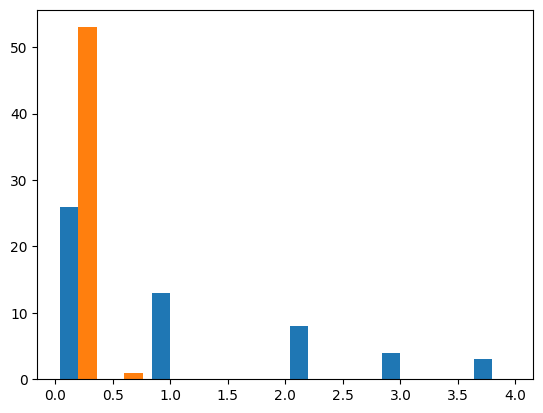

In [ ]:
plt.hist(data_er)

##Prior##

For my prior, I am choosing an exponential distribution, because the histogram looks kinda exponential and a pitcher could have an extremely high ER, so the tail is fitting.

<Axes: >

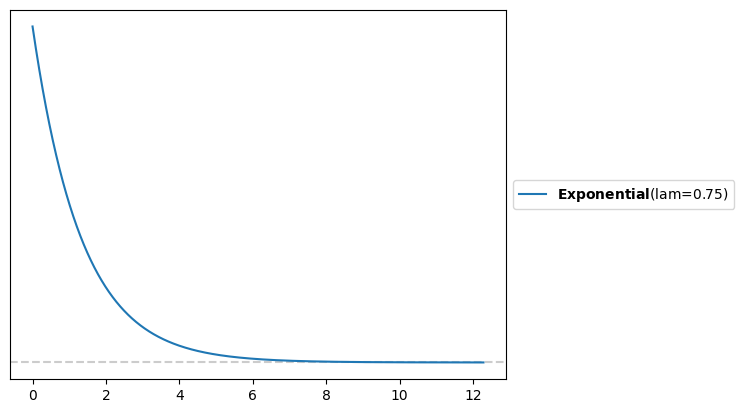

In [ ]:
prior = pz.Exponential(lam = 0.75)
prior.plot_pdf()

In [ ]:
prior.mean(),prior.skewness(), prior.kurtosis, prior.var()

(1.3333333333333333,
 2,
 <bound method Exponential.kurtosis of Exponential(lam=0.75)>,
 1.7777777777777777)

##Model 1: Categorical##

The first distribution I am choosing to model Gutierrez's future Earned Runs is the categorical distribution, because it is very simple and works with discrete data (which mine is, when you are counting runs, you can't have half a run).

In [ ]:
#C is for Categorical distribution
with pm.Model() as model_runC:
    #weak-ish prior for mean
    p1 = pm.Exponential('p', lam = 0.75)

    #likelihood
    y = pm.Categorical('y', p = p1, observed=data_er['ER'])

    idata_runC = pm.sample(1000)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'p_log__': array(0.81334008)}

Logp initial evaluation results:
{'p': -1.17, 'y': -inf}
You can call `model.debug()` for more details.

So for this distribution I need both my prior and my data to be vectors, so I will make a dataframe that containes probability vectors for my prior and add a column to my csv that includes the observed probabilities.

In [ ]:
prior1dat = {'col1': [.5,.25,.125,.0625,.03125,.015625,.0078125,.0078125]}
prior1 = pd.DataFrame(prior1dat)
prior1

,col1
0,0.500000
1,0.250000
2,0.125000
3,0.062500
4,0.031250
5,0.015625
6,0.007812
7,0.007812


In [ ]:
#C is for Categorical distribution
with pm.Model() as model_runC:

    #likelihood with vectors that sum to 1
    y = pm.Categorical('y', p = prior1, observed=data_er['1'])

    idata_runC = pm.sample(1000)

/usr/local/lib/python3.10/dist-packages/pymc/distributions/discrete.py:1142: UserWarning: `p` parameters sum to [[0.5       0.25      0.125     0.0625    0.03125   0.015625  0.0078125
  0.0078125]], instead of 1.0. They will be automatically rescaled. You can rescale them directly to get rid of this warning.
  warnings.warn(


SamplingError: Cannot sample from the model, since the model does not contain any free variables.

That didn't work because I didn't give my prior any degrees of freedom. After some research, I can use the Direchlet distribution for my prior.

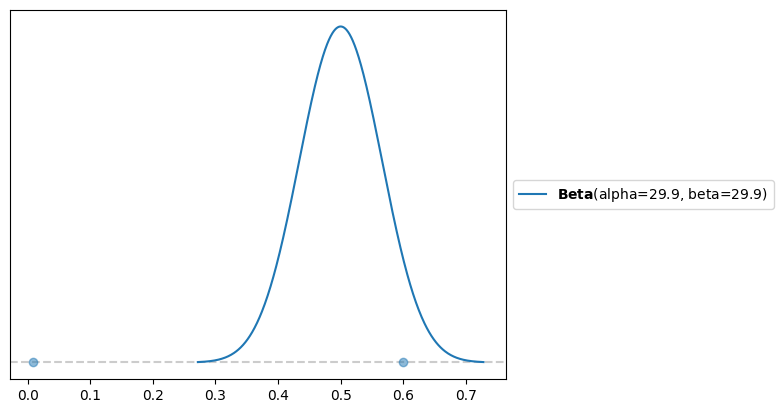

In [ ]:
prior2 = pz.unidimensional.beta_mode(lower = .0078125, upper = .6, mode = .5,)

Wait is that a beta distribution? I'm not sure. I will make another model after this one with my original prior.

In [ ]:
#C is for Categorical distribution
with pm.Model() as model_runC:
    #weak-ish prior for mean
    p2 = pm.Dirichlet('p2', lower = .0078125, upper = .6, mode = .5,)

    #likelihood
    y = pm.Categorical('y', p = p2, observed=data_er['ER'])

    idata_runC = pm.sample(1000)

TypeError: Dirichlet.dist() missing 1 required positional argument: 'a'

Nevermind I don't understand what this wants, so I am going to move on to a different distribution.

##Model 2: Poisson##

For this model, I am using the Poisson distribution because it represents the probability of a given number events occuring in a fixed time interval, provided the events occur independently of eachother. The first two parts are accurate, we are counting earned runs per one game, but they aren't entirely independent because one error can cause multiple runners to score or count as earned runs.

In [57]:
#P is for Poisson distribution
with pm.Model() as model_runP:
    #weak-ish prior for mean
    mu3 = pm.Exponential('p', lam = 0.75)

    #likelihood
    y = pm.Poisson('y', mu = mu3, observed=data_er['ER'])

    idata_runP = pm.sample(1000)

Output()

Output()

In [59]:
pm.sample_posterior_predictive(idata_runP, model=model_runP, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 10.0)

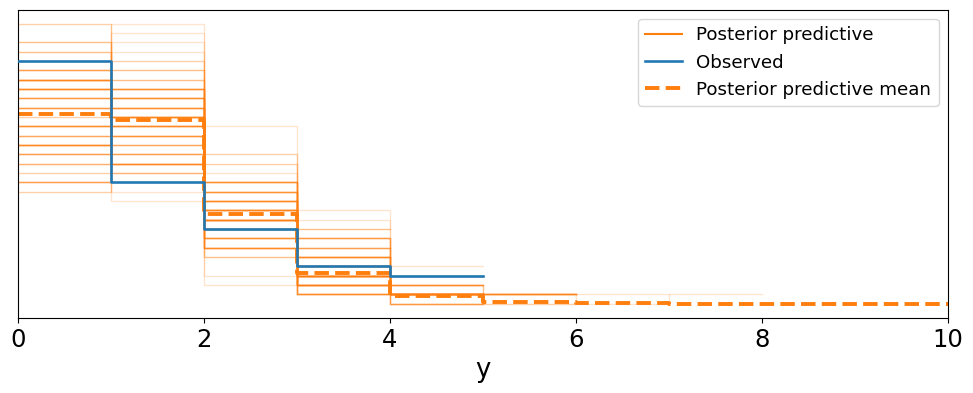

In [60]:
axL = az.plot_ppc(idata_runP, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
axL.set_xlim(0,10)

That is a lot more spread out than I want it to be, so I want to use a different distribution. The models predictions for 0 and 1 earned runs are especially spread. I don't entirely understand why, because my data matches my prior in shape, both rapidly decay, and is counted.

##Model 3: Zero Inflated Poisson##

I chose the zero inflated Poisson distribution as my next likely hood, because other than 0 and 1, the poisson was a pretty good fit.

In [67]:
#Z is for Zero Inflated Poisson distribution
with pm.Model() as model_runZ:
    #weak-ish prior for mean
    theta5 = pm.Exponential('theta', lam = 0.75)
    psi5 = pm.Uniform('psi', .25,.75)

    #likelihood
    y = pm.ZeroInflatedPoisson('y', mu = theta5, psi = psi5, observed=data_er['ER'])

    idata_runZ = pm.sample(1000)

Output()

Output()

In [68]:
pm.sample_posterior_predictive(idata_runZ, model=model_runZ, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 10.0)

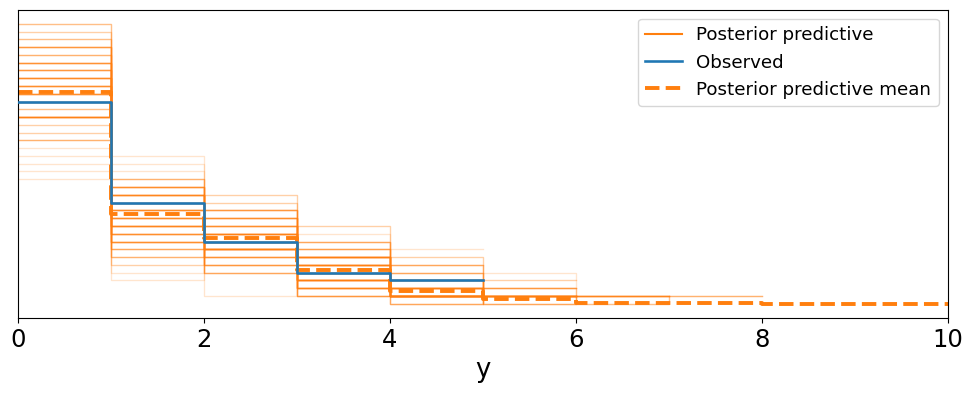

In [69]:
axL = az.plot_ppc(idata_runZ, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
axL.set_xlim(0,10)

That is a lot better, and much closer to what I would expect, but still isn't very tightly fitted to my data. I'm not sure where to go from here, because there aren't any other
